## **Marketing Promotion Campaign Uplift Modelling**    
#### Customer Retention data for Churn Prediction or Uplift Modelling

**Description / Задание:**  
1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:72,5% !important; }</style>"))

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Пути к директориям и файлам

In [5]:
TRAIN_DATASET_PATH = './Customer Retention/data.csv'

### Загрузка данных

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

In [7]:
# Количество строк и колонок в датафрейме
print(train_df.shape)

(64000, 9)


In [8]:
# Просмотр записей(строк) из начала датафрейма
train_df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44000,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08000,1,1,Rural,1,Web,No Offer,0
2,7,180.65000,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83000,1,0,Rural,1,Web,Discount,0
4,2,45.34000,1,0,Urban,0,Web,Buy One Get One,0


In [9]:
# Cведения о датафрейме
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [10]:
# Переименование столбцов
def rename_func(df):    
    df.rename(columns={'conversion': 'target', 'offer': 'treatment', 
    }, inplace=True)
    
rename_func(train_df)

In [11]:
train_df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [12]:
# Преобразование из категориальной переменной в числовую.
train_df.loc[train_df['treatment'] == 'Buy One Get One', 'treatment'] = 1
train_df.loc[train_df['treatment'] == 'Discount', 'treatment'] = 1
train_df.loc[train_df['treatment'] == 'No Offer', 'treatment'] = 0

train_df['treatment'] = pd.to_numeric(train_df['treatment'])

In [13]:
# Проверяем результат записей(строк) из начала датафрейма
train_df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44000,1,0,Surburban,0,Phone,1,0
1,6,329.08000,1,1,Rural,1,Web,0,0
2,7,180.65000,0,1,Surburban,1,Web,1,0
3,9,675.83000,1,0,Rural,1,Web,1,0
4,2,45.34000,1,0,Urban,0,Web,1,0


### Подготовка признаков

In [14]:
X = pd.get_dummies(train_df)
X.drop('target', axis=1, inplace=True)
y = train_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Корреляция признаков

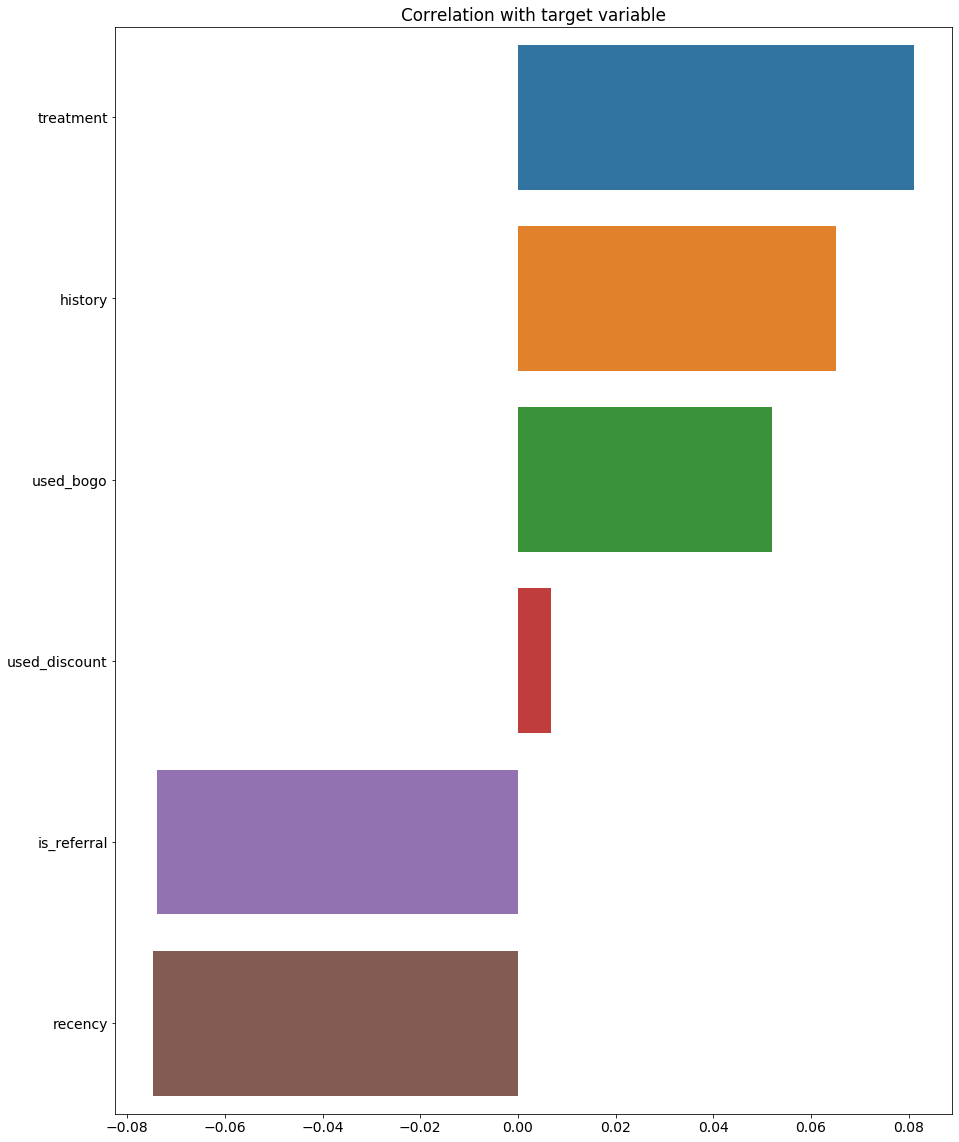

In [15]:
TARGET_NAME = 'target'

corr_with_target = train_df.corr()[TARGET_NAME].sort_values(ascending=False)[1:]

plt.figure(figsize=(15, 20))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()